# GLMM 負の二項分布回帰

ポアソン分布が過分散のときに使用できる分布が負の二項分布であり，ポアソン回帰が過剰に精密に推定してしまうことを防ぐために使用される．

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gpboost as gpb
# https://gpboost.readthedocs.io/en/latest/pythonapi/gpboost.GPModel.html

from patsy import dmatrix

In [2]:
filepath = '../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath)
df['log_income'] = np.log(df['income'])
df = df.dropna()
df.head()

,island,year,island_id,region_code,region_name,prefecture_code,prefecture_code.1,population,dummy_island_has_bridge,dummy_island_is_connected_mainland,year_bridge_opened,dummy_after_bridge_opened,year_connect_mainland,dummy_after_connect_mainland,income,log_income
2,島後,2005,0,32528,隠岐の島町,32,島根県,17259.0,0,0,0,0,0,0,19083931.0,16.764357
3,島後,2010,0,32528,隠岐の島町,32,島根県,15930.0,0,0,0,0,0,0,16082881.0,16.593266
4,島後,2015,0,32528,隠岐の島町,32,島根県,14901.0,0,0,0,0,0,0,16135317.0,16.596521
5,島後,2020,0,32528,隠岐の島町,32,島根県,13882.0,0,0,0,0,0,0,17473739.0,16.676210
6,中ノ島,1985,1,32525,海士町,32,島根県,3339.0,0,0,0,0,0,0,2645758.0,14.788468


## 人口の平均と分散

In [3]:
mean_population = np.mean(df['population'])
std_population = np.std(df['population'])

print(f'mean_population: {mean_population}')
print(f'std_population: {std_population}')

mean_population: 2317.68085106383
std_population: 5886.239145207748


## モデルの適合

In [6]:
group = df['island_id']
y = df['population']
X = dmatrix('dummy_after_bridge_opened + log_income + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC     BIC
-3632.39 7286.77 7335.34
Nb. observations: 611
Nb. groups: 154 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  4.5719
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                           Param.  Std. dev.  z value  P(>|z|)
Intercept                  6.1888     0.2151  28.7703   0.0000
C(year)[T.1990]           -0.0729     0.0489  -1.4884   0.1366
C(year)[T.1995]           -0.0854     0.0407  -2.0982   0.0359
C(year)[T.2000]           -0.2006     0.0451  -4.4473   0.0000
C(year)[T.2005]           -0.0647     0.0336  -1.9247   0.0543
C(year)[T.2010]           -0.2258     0.0363  -6.2268   0.0000
C(year)[T.2015]           -0.3800     0.0366 -10.3797   0.0000
C(year)[T.2020]           -0.5576     0.0368 -15.1437   0.0000
dummy_after_bridge_opened  0.0127     0.0111   1.1371   0.2555
log_income             

## 残差分析

In [7]:
# 変数と残差の相関
corr_log_income = np.corrcoef(df['log_income'], residuals)[0, 1]
corr_bridge = np.corrcoef(df['dummy_after_bridge_opened'], residuals)[0, 1]
coor_population = np.corrcoef(df['population'], residuals)[0, 1]

print(f'coor between log_income and residuals: {corr_log_income:.3f}')
print(f'coor between bridge and residuals: {corr_bridge:.3f}')
print(f'coor between population and residuals: {coor_population:.3f}')

coor between log_income and residuals: 0.040
coor between bridge and residuals: -0.031
coor between population and residuals: -0.014


### 残差プロット

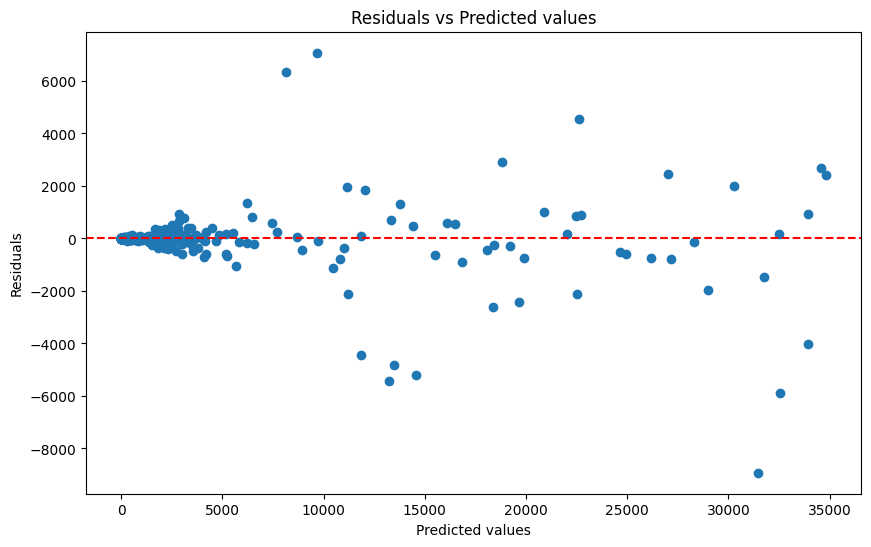

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals)
plt.axhline(0, color='red', ls='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

### 残差ヒストグラム

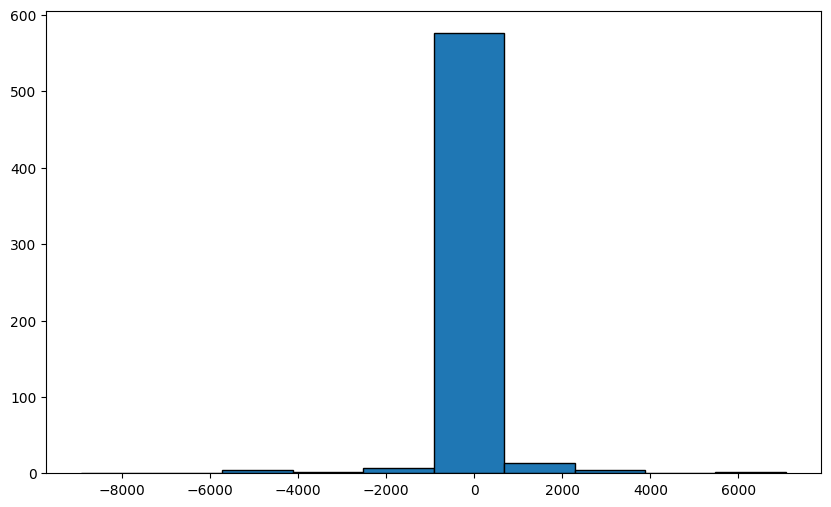

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, edgecolor='black')
plt.show()